<a href="https://colab.research.google.com/github/oziomaozigbo/SMCR/blob/main/Earth_Heat_2Nrevsimsysclaudeai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import numpy as np , matplotlib.pyplot as plt

# Earth Heat 2N

ao__dz =  250.0
al__dz =  200.0
Ocean depth: 3150 m
Land thickness: 8.4 m
Land fraction: 0.292
Ocean fraction: 0.708

EARTH CLIMATE MODEL: LAND + OCEAN VERSION

time_step= 2.0 hr ...  number of time steps= 87600
T_atm_init =  [ 15.  11.   4.  -6. -17. -30. -44. -59.]
T_ocn_init =  [19. 16. 13. 11.  9.  7.  5.  3.]
T_land_init =  [15. 14. 12. 10.  8.  6.  3.  1.]

=== FINAL RESULTS (Year 15.0 ) ===
Atmosphere surface T: 18.32 °C
Ocean surface T: 22.76 °C
Land surface T: 25.57 °C
Global avg surface T: 23.58 °C

Full atmosphere profile: [ 18.  -0. -15. -27. -38. -47. -54. -58.]
Full ocean profile: [23. 19. 15. 12.  9.  7.  5.  4.]
Full land profile: [26. 26. 26. 26. 26. 26. 26. 26.]


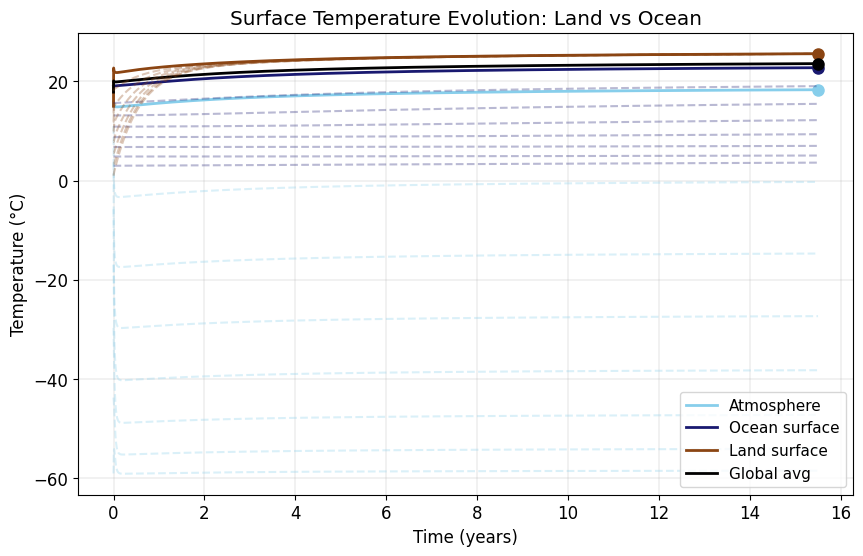

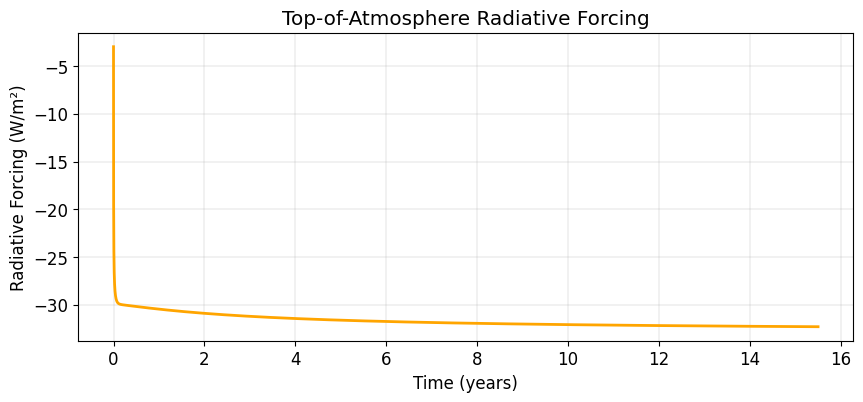

In [94]:
# ODE4U function

# ODE4U function (unchanged)
def ode4u(odefun, time, x0, u=None, c=None):
    """
    Solve a system of nonhomogeneous ODEs using the 4th-order Runge-Kutta method.
    """
    time   = np.asarray(time)
    x0     = np.asarray(x0).flatten()
    points = len(time)

    if c is None:
        c = 0
    if u is None:
        u = np.zeros((1, points))
    else:
        u = np.asarray(u)

    if u.ndim == 1:
        u = u[np.newaxis, :]

    if u.shape[1] < points:
        pad_width = points - u.shape[1]
        u = np.pad(u, ((0, 0), (0, pad_width)), mode='constant')

    dxdt0, y0 = odefun(time[0], x0, u[:, 0], c)

    n = x0.size
    m = np.asarray(y0).size

    x_sol = np.ones([n, points])*np.nan
    x_drv = np.ones([n, points])*np.nan
    y_sol = np.ones([m, points])*np.nan

    x_sol[:, 0] = x0
    x_drv[:, 0] = dxdt0
    y_sol[:, 0] = y0

    for p in range(points - 1):
        t = time[p]
        dt = time[p + 1] - t
        dt2 = dt / 2.0

        u_mid = (u[:, p] + u[:, p + 1]) / 2.0

        dxdt1, _ = odefun(t + dt2, x0 + dxdt0 * dt2, u_mid, c)
        dxdt2, _ = odefun(t + dt2, x0 + dxdt1 * dt2, u_mid, c)
        dxdt3, _ = odefun(t + dt,  x0 + dxdt2 * dt, u[:, p + 1], c)

        x0 = x0 + ( dxdt0 + 2 * (dxdt1 + dxdt2) + dxdt3 ) * dt / 6.0

        dxdt0, y0 = odefun(time[p + 1], x0, u[:, p + 1], c)

        x_sol[:, p+1] = x0
        x_drv[:, p+1] = dxdt1
        y_sol[:, p+1] = y0

        if not np.all(np.isfinite(x0)):
            break

    return time, x_sol, x_drv, y_sol


# Planetary constants with LAND-OCEAN SEPARATION
class c:
    pi  =   np.pi
    c   =  299.792458e6
    h   =    6.62607015e-34
    k   =    1.380649e-23
    sbc =    5.670367e-8        # Stefan-Boltzman constant  W/(m²·K⁴)
    Ts  = 5777.
    Rs  =    6.9570e08
    D   =    1.4960e11
    Re  =    6.3567523e6
    sec_per_yr = 365*24*3600
    aa     =  0.35            # earth albedo
    ee_atm =  0.78            # atmos emissivity
    ee_ocn =  0.96            # ocean emissivity
    ee_land = 0.95            # land emissivity (similar to ocean)
    years  = 20
    n_layer = 8
    T_strat = 273 - 60
    atm_density_s = 1.23
    atm_density_t = 0.32
    atm_shc = 1003
    atm_heat_transfer =  3.7
    atm_elvtn = 12650

    # OCEAN properties
    ocn_atm_heat_transfer = 40    # ocean-atmosphere heat transfer
    ocn_shc = 4000
    ocn_density = 1023.6
    ocn_heat_transfer =  4.0
    ocn_depth = 3150              # average ocean depth

    # LAND properties
    land_atm_heat_transfer = 25   # land-atmosphere heat transfer (less than ocean)
    land_thickness = 8.4          # equivalent water thickness of land (m)
    land_area_fraction = 0.292    # fraction of earth that is land
    land_shc = 800                # soil/rock specific heat capacity J/(kg·K)
    land_density = 2000           # soil/rock density kg/m³

    # Computed constants
    solar_const = sbc*Ts**4.0 * 4*pi*Rs**2 / (4*pi*D**2.0)

    # ATMOSPHERE layers (same for everywhere)
    atm_z = atm_elvtn * np.hstack([0, np.logspace(-1.5, 0.0, n_layer)])
    atm_tz = atm_z[1:n_layer+1] - atm_z[0:n_layer]
    atm_dz = 0.5*(atm_z[2:n_layer+1] - atm_z[0:n_layer-1])

    # OCEAN layers
    ocn_z = ocn_depth * np.hstack([0, -np.logspace(-1.5, 0.0, n_layer)])
    ocn_tz = ocn_z[0:n_layer] - ocn_z[1:n_layer+1]
    ocn_dz = 0.5*(ocn_z[0:n_layer-1] - ocn_z[2:n_layer+1])

    # LAND layers (much thinner!)
    land_z = land_thickness * np.hstack([0, -np.logspace(-1.5, 0.0, n_layer)])
    land_tz = land_z[0:n_layer] - land_z[1:n_layer+1]
    land_dz = 0.5*(land_z[0:n_layer-1] - land_z[2:n_layer+1])

    ao__dz = 0.5*(atm_z[1] - ocn_z[1])
    al__dz = 0.5*(atm_z[1] - land_z[1])

    print("ao__dz = ", np.round(ao__dz))
    print("al__dz = ", np.round(al__dz))
    print("Ocean depth:", ocn_depth, "m")
    print("Land thickness:", land_thickness, "m")
    print("Land fraction:", land_area_fraction)
    print("Ocean fraction:", 1 - land_area_fraction)

    # Atmospheric density (exponential with altitude)
    atm_density_decay = atm_elvtn/np.log(atm_density_s / atm_density_t)
    atm_density = atm_density_s * np.exp(-(atm_z[0:n_layer]+0.5*atm_tz)/atm_density_decay)

    # Area heat capacities (per unit area)
    atm_ahc = atm_shc * atm_density * atm_tz
    ocn_ahc = ocn_shc * ocn_density * ocn_tz
    land_ahc = land_shc * land_density * land_tz


# System dynamics with LAND and OCEAN
def sys(t, x, u, c):
    """
    State vector x now has:
    - N atmosphere layers (globally averaged)
    - N ocean layers (for ocean fraction)
    - N land layers (for land fraction)

    Total: 3*N states
    """
    N = c.n_layer

    # Extract states
    Q_atm = x[0:N]        # Atmosphere heat (J/m² global average)
    Q_ocn = x[N:2*N]      # Ocean heat (J/m² ocean area)
    Q_land = x[2*N:3*N]   # Land heat (J/m² land area)

    # Convert to temperatures
    T_atm = np.maximum(0.0, Q_atm / c.atm_ahc)
    T_ocn = np.maximum(0.0, Q_ocn / c.ocn_ahc)
    T_land = np.maximum(0.0, Q_land / c.land_ahc)

    # ATMOSPHERE heat balance (globally averaged)
    # ============================================
    dQ_atm_dt = np.ones(N)*np.nan

    # Surface radiative output (weighted average of land and ocean)
    f_ocn = 1 - c.land_area_fraction
    f_land = c.land_area_fraction

    R_out_U = f_ocn * c.ee_ocn * c.sbc * T_ocn[0]**4 + \
              f_land * c.ee_land * c.sbc * T_land[0]**4

    for k in range(N):
        T_L = T_atm[k-1]
        h_L = c.atm_heat_transfer

        if k == 0:
            # Bottom atmospheric layer couples to both ocean and land
            # Weighted average temperature
            T_L = f_ocn * T_ocn[0] + f_land * T_land[0]
            h_L = f_ocn * c.ocn_atm_heat_transfer + f_land * c.land_atm_heat_transfer

        if k == N-1:
            T_U = c.T_strat
        else:
            T_U = T_atm[k+1]

        h_U = c.atm_heat_transfer

        # Radiative transfer
        R_in_L = R_out_U
        R_in_U = c.ee_atm * c.sbc * T_U**4
        R_out_L = (1-c.ee_atm) * R_in_U + c.ee_atm * c.sbc * T_atm[k]**4
        R_out_U = (1-c.ee_atm) * R_in_L + c.ee_atm * c.sbc * T_atm[k]**4

        dQ_atm_dt[k] = R_in_L + R_in_U - R_out_L - R_out_U + \
                       h_L * (T_L - T_atm[k]) + h_U * (T_U - T_atm[k])

    # OCEAN heat balance (per unit ocean area)
    # =========================================
    dQ_ocn_dt = np.ones(N)*np.nan

    for k in range(N):
        T_U = T_ocn[k-1]
        h_U = c.ocn_heat_transfer
        u0 = 0

        if k == 0:
            # Surface ocean layer
            T_U = T_atm[0]
            h_U = c.ocn_atm_heat_transfer

            # Solar input (only ocean receives the ocean fraction)
            u0 = u[0] - c.ee_ocn * c.sbc * T_ocn[0]**4 + \
                 (1-c.ee_atm) * c.sbc * T_atm[1]**4 + \
                 c.ee_atm * c.sbc * T_atm[0]**4

        if k == N-1:
            h_L = 0
            T_L = T_ocn[k]
        else:
            T_L = T_ocn[k+1]
            h_L = c.ocn_heat_transfer

        dQ_ocn_dt[k] = u0 + h_L * (T_L - T_ocn[k]) + h_U * (T_U - T_ocn[k])

    # LAND heat balance (per unit land area)
    # =======================================
    dQ_land_dt = np.ones(N)*np.nan

    for k in range(N):
        T_U = T_land[k-1]
        h_U = c.ocn_heat_transfer  # Use same as ocean for subsurface
        u0 = 0

        if k == 0:
            # Surface land layer
            T_U = T_atm[0]
            h_U = c.land_atm_heat_transfer

            # Solar input (only land receives the land fraction)
            u0 = u[1] - c.ee_land * c.sbc * T_land[0]**4 + \
                 (1-c.ee_atm) * c.sbc * T_atm[1]**4 + \
                 c.ee_atm * c.sbc * T_atm[0]**4

        if k == N-1:
            h_L = 0
            T_L = T_land[k]
        else:
            T_L = T_land[k+1]
            h_L = c.ocn_heat_transfer  # Same vertical mixing as ocean

        dQ_land_dt[k] = u0 + h_L * (T_L - T_land[k]) + h_U * (T_U - T_land[k])

    # Radiative forcing (at top of atmosphere)
    RF = c.sbc * ((1-c.ee_atm)*T_atm[1]**4 + c.ee_atm * T_atm[0]**4 - \
                  f_ocn * c.ee_ocn * T_ocn[0]**4 - \
                  f_land * c.ee_land * T_land[0]**4)

    # State derivatives
    dxdt = np.hstack([dQ_atm_dt, dQ_ocn_dt, dQ_land_dt])

    # Outputs
    y = np.hstack([T_atm, T_ocn, T_land, RF])

    return dxdt, y


# Run simulation
def run():
    N = c.n_layer

    # Time
    time_end = c.sec_per_yr * c.years
    time_step = c.sec_per_yr / (12*365)
    n_time = int(time_end / time_step)
    dt = time_step * np.ones(n_time)
    n_ramp = int(c.sec_per_yr * 9 / time_step)
    k_ramp = np.linspace(0, n_ramp-1, n_ramp)
    dt[0:n_ramp] = time_step * (np.sin(2*np.pi*k_ramp/n_ramp/4))**2.0
    time = np.cumsum(dt)

    print("time_step=", time_step/3600, "hr ...  number of time steps=", n_time)

    # Initial temperatures (K)
    T_atm_init = 15 - 74 * np.linspace(0, 1, N)**1.5
    T_ocn_init = 19 - 16 * np.linspace(0, 1, N)**0.8
    T_land_init = 15 - 14 * np.linspace(0, 1, N)**1.2  # Land: similar to atm surface, cold at depth

    print("T_atm_init = ", np.round(T_atm_init))
    print("T_ocn_init = ", np.round(T_ocn_init))
    print("T_land_init = ", np.round(T_land_init))

    # Initial heat content
    x_init = np.hstack([c.atm_ahc * (T_atm_init + 273),
                        c.ocn_ahc * (T_ocn_init + 273),
                        c.land_ahc * (T_land_init + 273)])

    # External forcing: [ocean solar input, land solar input]
    solar_in = (1 - c.aa) * (c.solar_const / 4)
    u = np.zeros((2, n_time))
    u[0, :] = solar_in  # Ocean gets same solar per m²
    u[1, :] = solar_in  # Land gets same solar per m²

    # Solve ODEs
    time, x, x_drv, y = ode4u(sys, time, x_init, u, c)

    time = time / c.sec_per_yr

    T_atm = y[0:N, :] - 273
    T_ocn = y[N:2*N, :] - 273
    T_land = y[2*N:3*N, :] - 273
    RF = y[3*N]

    # Global average surface temperature (area-weighted)
    f_ocn = 1 - c.land_area_fraction
    f_land = c.land_area_fraction
    T_surface_avg = f_ocn * T_ocn[0, :] + f_land * T_land[0, :]

    # Print results
    print("\n=== FINAL RESULTS (Year", np.round(time[-1]), ") ===")
    print("Atmosphere surface T:", np.round(T_atm[0, -1], 2), "°C")
    print("Ocean surface T:", np.round(T_ocn[0, -1], 2), "°C")
    print("Land surface T:", np.round(T_land[0, -1], 2), "°C")
    print("Global avg surface T:", np.round(T_surface_avg[-1], 2), "°C")
    print("\nFull atmosphere profile:", np.round(T_atm[:, -1]))
    print("Full ocean profile:", np.round(T_ocn[:, -1]))
    print("Full land profile:", np.round(T_land[:, -1]))

    # Plotting
    fontsize = 12
    plt.rcParams['font.size'] = fontsize
    plt.ion()

    # Figure 1: Temperature evolution
    f1 = plt.figure(1, figsize=(10, 6))
    plt.clf()

    plt.plot(time, T_atm[0, :], "-", color='SkyBlue', linewidth=2, label="Atmosphere")
    plt.plot(time, T_ocn[0, :], "-", color='MidnightBlue', linewidth=2, label="Ocean surface")
    plt.plot(time, T_land[0, :], "-", color='SaddleBrown', linewidth=2, label="Land surface")
    plt.plot(time, T_surface_avg, "-", color='Black', linewidth=2, label="Global avg")

    plt.plot(time[-1], T_atm[0, -1], "o", color='SkyBlue', markersize=8)
    plt.plot(time[-1], T_ocn[0, -1], "o", color='MidnightBlue', markersize=8)
    plt.plot(time[-1], T_land[0, -1], "o", color='SaddleBrown', markersize=8)
    plt.plot(time[-1], T_surface_avg[-1], "o", color='Black', markersize=8)

    # Plot deeper layers
    for k in range(1, N):
        plt.plot(time, T_atm[k, :], "--", color='SkyBlue', alpha=0.3)
        plt.plot(time, T_ocn[k, :], "--", color='MidnightBlue', alpha=0.3)
        plt.plot(time, T_land[k, :], "--", color='SaddleBrown', alpha=0.3)

    plt.ylabel('Temperature (°C)')
    plt.xlabel('Time (years)')
    plt.legend(loc='lower right', fontsize=fontsize-1)
    plt.grid(lw=0.25)
    plt.title("Surface Temperature Evolution: Land vs Ocean")

    # Figure 2: Radiative forcing
    f2 = plt.figure(2, figsize=(10, 4))
    plt.clf()
    plt.plot(time, RF, "-", color='Orange', linewidth=2)
    plt.ylabel('Radiative Forcing (W/m²)')
    plt.xlabel('Time (years)')
    plt.grid(lw=0.25)
    plt.title("Top-of-Atmosphere Radiative Forcing")

    plt.show()

    return time, T_atm, T_ocn, T_land, T_surface_avg


# Run the model
if __name__ == "__main__":
    print("\n" + "="*60)
    print("EARTH CLIMATE MODEL: LAND + OCEAN VERSION")
    print("="*60 + "\n")
    time, T_atm, T_ocn, T_land, T_surface_avg = run()

time_step= 2.0 hr ...  number of time steps= 87600
T_atm_init =  [ 15.  11.   4.  -6. -17. -30. -44. -59.]
T_ocn_init =  [19. 16. 13. 11.  9.  7.  5.  3.]
T_land_init =  [15. 14. 12. 10.  8.  6.  3.  1.]

=== FINAL RESULTS (Year 15.0 ) ===
Atmosphere surface T: 18.32 °C
Ocean surface T: 22.76 °C
Land surface T: 25.57 °C
Global avg surface T: 23.58 °C

Full atmosphere profile: [ 18.  -0. -15. -27. -38. -47. -54. -58.]
Full ocean profile: [23. 19. 15. 12.  9.  7.  5.  4.]
Full land profile: [26. 26. 26. 26. 26. 26. 26. 26.]


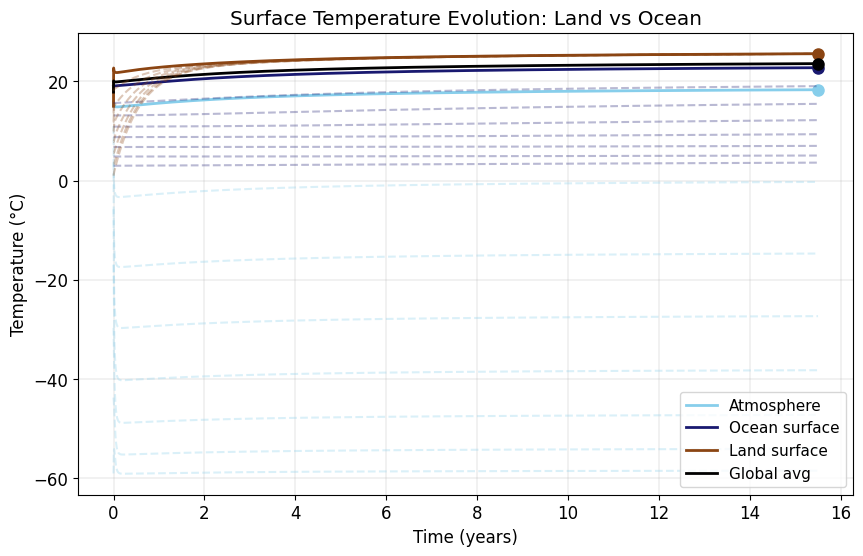

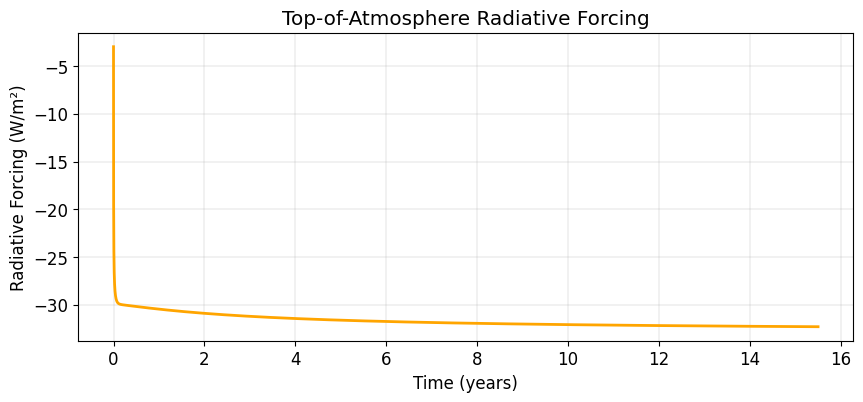

(array([0.00000000e+00, 3.62520361e-13, 1.81260180e-12, ...,
        1.54994292e+01, 1.54996575e+01, 1.54998858e+01]),
 array([[ 15.        ,  15.        ,  15.        , ...,  18.31843803,
          18.31844723,  18.31845643],
        [ 11.00437557,  11.00437557,  11.00437556, ...,  -0.26153104,
          -0.26152282,  -0.2615146 ],
        [  3.69866748,   3.69866748,   3.69866748, ..., -14.69159731,
         -14.69158992, -14.69158252],
        ...,
        [-29.67243918, -29.67243918, -29.67243918, ..., -47.20368522,
         -47.2036808 , -47.20367638],
        [-43.72344633, -43.72344633, -43.72344633, ..., -54.05567287,
         -54.05566972, -54.05566656],
        [-59.        , -59.        , -59.        , ..., -58.44912968,
         -58.44912799, -58.44912629]]),
 array([[19.        , 19.        , 19.        , ..., 22.75806062,
         22.75807059, 22.75808056],
        [15.6268042 , 15.6268042 , 15.6268042 , ..., 19.0420919 ,
         19.04210817, 19.04212444],
        [13.12

In [95]:
run()